In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [5]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]


In [6]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_x, train_y = features[:-60*24], targets[:-60*24]
val_x, val_y = features[-60*24:], targets[-60*24:]

In [7]:
def model_inputs(num_features):
    inputs = tf.placeholder(tf.float32, [None, num_features], name='inputs')
    targets = tf.placeholder(tf.float32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32, None, name='keep_prob')
    
    return(inputs, targets, lr, keep_prob)

In [8]:
def network(inputs, keep_prob, size):
    #layers
    with tf.name_scope('Layer1'):
        layer1 = tf.contrib.layers.fully_connected(inputs, size//2)
        layer1 = tf.nn.dropout(layer1, keep_prob)
    
    with tf.name_scope('Layer2'):
        layer2 = tf.contrib.layers.fully_connected(layer1, size)
        layer2 = tf.nn.dropout(layer2, keep_prob)
    
    with tf.name_scope('Layer3'):
        layer3 = tf.contrib.layers.fully_connected(layer2, size//2)
        layer3 = tf.nn.dropout(layer3, keep_prob)
    
    with tf.name_scope('LayerOut'):
        out = tf.contrib.layers.fully_connected(layer3, 1, None)
    return(out)

In [9]:
epoch = 1000
batch_size = 128
size = 512
learning_rate = 0.00002
num_features = 58
keep_probability = 0.7
display_steps = 5


In [10]:
save_path = 'weights/DNN'

train_graph = tf.Graph()
with train_graph.as_default():
    inputs, targets, lr, keep_prob = model_inputs(num_features)
    train_logits = network(inputs, keep_prob, size)
    
    training_logits = tf.identity(train_logits, name='training_logits')
    
    with tf.name_scope('optimization'):
        cost = tf.reduce_mean(tf.squared_difference(training_logits, targets))
        optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

In [11]:
def get_batches(inputs, targets, batch_size):
    for batch_i in range(0, len(inputs)//batch_size):
        
        start_i = batch_i * batch_size
        
        inputs_batch = np.array(inputs[start_i:start_i+batch_size])
        targets_batch = np.array(targets[start_i:start_i+batch_size])
        
        yield(inputs_batch, targets_batch)

In [15]:
def get_accuracy(target, logits):
    try:
        return(np.mean((target - logits)**2))
    except:
        return(0.000)

losses = {'train':[], 'validation':[]}
train_inputs = train_x[batch_size:]
train_targets = train_y[batch_size:]
valid_inputs = val_x[:batch_size]
valid_targets = val_y[:batch_size]
(valid_inputs_batch, valid_targets_batch) = next(get_batches(valid_inputs, valid_targets, batch_size))

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('.logs/')
    writer.add_graph(sess.graph)
    
    for epoch_i in range(epoch):
        for batch_i, (inputs_batch, targets_batch) in enumerate(
                get_batches(train_inputs, train_targets, batch_size)):
            _, loss = sess.run([optimizer, cost],
                              {inputs:inputs_batch,
                               targets:targets_batch,
                               lr:learning_rate,
                               keep_prob:keep_probability})
            
            if batch_i % display_steps == 0 and batch_i > 0:
                
                batch_train_logits = sess.run(training_logits,
                                             {inputs:inputs_batch,
                                              targets:targets_batch,
                                              lr:learning_rate,
                                              keep_prob:1.0})
                
                batch_valid_logits = sess.run(training_logits,
                                             {inputs:valid_inputs_batch,
                                              targets:valid_targets_batch,
                                              lr:learning_rate,
                                              keep_prob:1.0})
                
                train_acc = get_accuracy(targets_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)
                losses['train'].append(train_acc)
                losses['validation'].append(valid_acc)
                
                sys.stdout.write('\rProgress: {:2.1f} Epoch {:>3} Batch {:>4}/{} - Train MSE: {:>6.8f}, Validation MSE: {:>6.8f}, Loss: {:>6.8f}'
                      .format(100*epoch_i/float(epoch), epoch_i, batch_i, len(train_x) // batch_size, train_acc, valid_acc, loss))
                sys.stdout.flush()
                
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('\nModel Trained and Saved')

Progress: 99.9 Epoch 999 Batch  115/120 - Train MSE: 0.17073229, Validation MSE: 0.17679547, Loss: 0.01309904
Model Trained and Saved


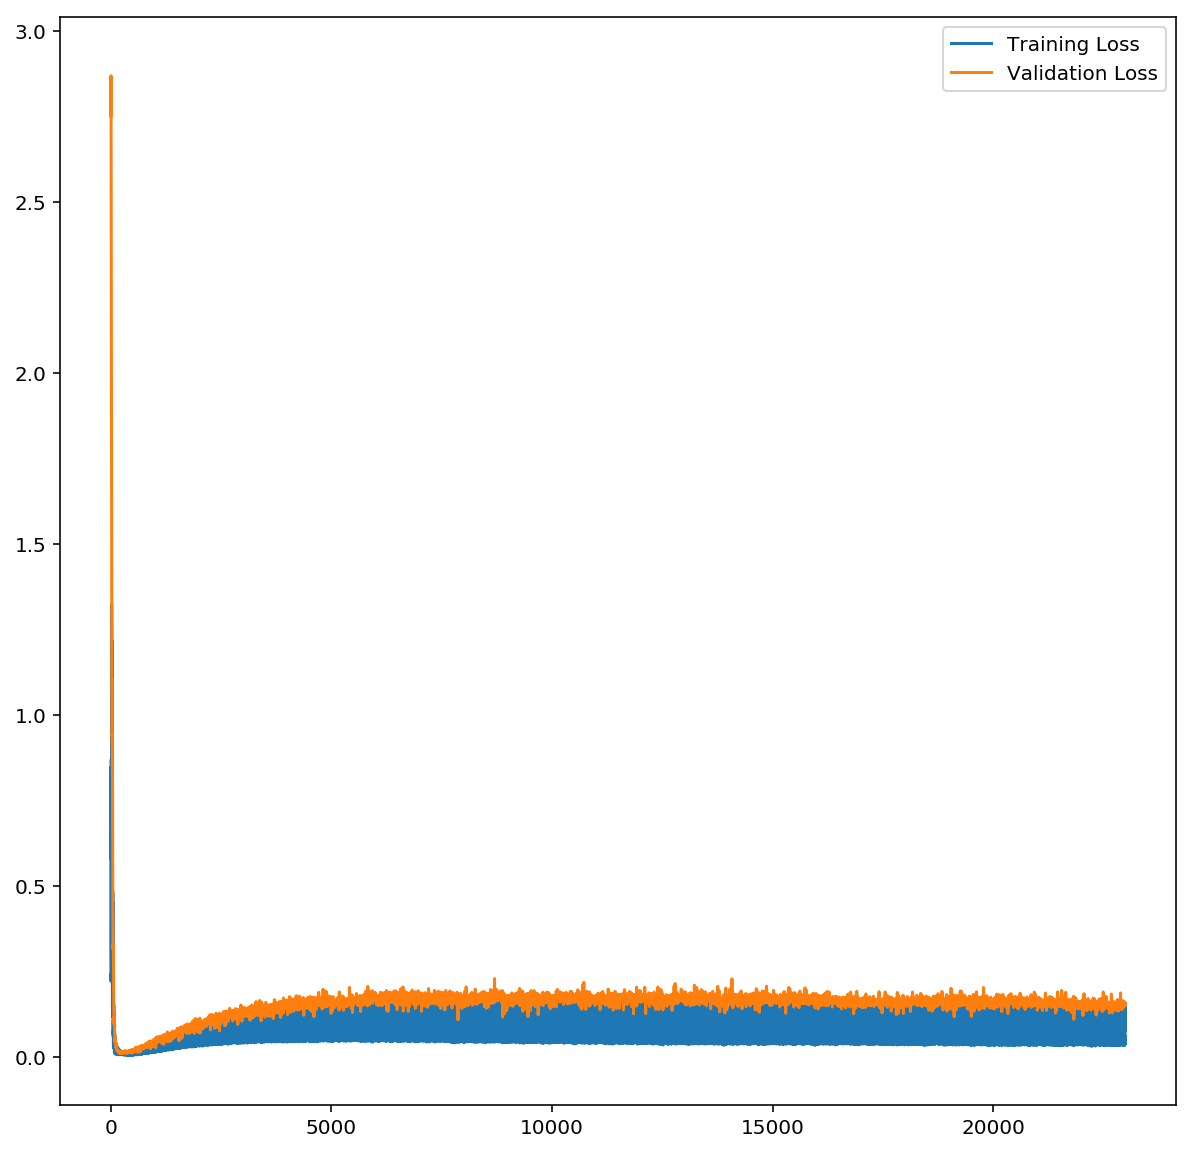

In [13]:
plt.figure(figsize=(10,10))
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['validation'], label='Validation Loss')
plt.legend()
_ = plt.ylim()

In [14]:
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader = tf.train.import_meta_data(save_path + '.meta')
    loader.restore(sess, load_path)
    
    input_data = loaded_graph.get_tensor_by_name('inputs:0')
    logits = loaded_graph.get_tensor_by_name('training_logits:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob')
    
    prediction = sess.run(training_logits, {input_data})

AttributeError: module 'tensorflow.python.training.training' has no attribute 'import_meta_data'